In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# 1. Create Spark Session (spark variable usually already exists in Dataproc Notebook, but this line won't cause an error)
spark = SparkSession.builder.appName("ECommerceAnalysis-March").getOrCreate()

# 2. Read data (replace with your actual GCS path)
# Tip: You can read just 1000 rows to test the code, then switch to the full dataset
input_path = "gs://final_project_datapro/2020-Mar.csv"
df = spark.read.csv(input_path, header=True, inferSchema=True)

# 3. Check if data loaded successfully (easy in Notebook)
print("orignal data preview：")
df.show(20)

# 4. Data Cleaning & Feature Engineering (core requirement from your PDF)
# We will transform the data step-by-step

# Convert price and timestamp formats
df_cleaned = df.dropna(subset=["user_id", "product_id", "event_type"]) \
               .withColumn("price", F.col("price").cast("double"))

# [cite_start]To calculate the Key Metrics required by the PDF [cite: 87]
# First, break down event_type into numerical flags (One-Hot encoding idea)
df_features = df_cleaned.withColumn("is_view", F.when(F.col("event_type") == "view", 1).otherwise(0)) \
                        .withColumn("is_cart", F.when(F.col("event_type") == "cart", 1).otherwise(0)) \
                        .withColumn("is_purchase", F.when(F.col("event_type") == "purchase", 1).otherwise(0)) \
                        .withColumn("purchase_amt", F.when(F.col("event_type") == "purchase", F.col("price")).otherwise(0))

# 5. Aggregate to generate User Profiles
# This step converts "massive raw data" into "user-level profiles"
user_profile = df_features.groupBy("user_id").agg(
    F.sum("is_view").alias("view_freq"),        # View Frequency
    F.sum("is_cart").alias("cart_freq"),
    F.sum("is_purchase").alias("purchase_freq"), # Purchase Frequency
    F.sum("purchase_amt").alias("total_spend"),
    F.min("event_time").alias("first_time"),
    F.max("event_time").alias("last_time")
)
# 6. Calculate derived metrics (add-to-cart rate, avg spending, duration)
final_df = user_profile.withColumn(
    "add_to_cart_rate",
    F.when(F.col("view_freq") > 0, F.col("cart_freq") / F.col("view_freq")).otherwise(0) # Add-to-cart rate
).withColumn(
    "avg_spending",
    F.when(F.col("purchase_freq") > 0, F.col("total_spend") / F.col("purchase_freq")).otherwise(0) # Average spending
).withColumn(
    "session_duration_sec",
    F.col("last_time").cast("long") - F.col("first_time").cast("long") # Session duration
)

# 7. Check the final result
print("User profile preview：")
final_df.show(20)

# 8. Save as a single CSV file

# 1. Define a folder path, Spark will create it automatically
# We'll name it "user_features_csv_output"
# to distinguish it from Parquet
# output_path = "gs://final_project_datapro/user_features_March_csv_output"

# 2. Execute save
# .coalesce(1) is key: it forces Spark to merge all data into 1 partition,
# so it will only generate 1 CSV file
# final_df.coalesce(1).write.mode("overwrite").csv(output_path, header=True)

# print(f"Data saved as CSV, please check the folder on GCS: {output_path}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/17 01:20:02 INFO SparkEnv: Registering MapOutputTracker
25/11/17 01:20:02 INFO SparkEnv: Registering BlockManagerMaster
25/11/17 01:20:02 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/11/17 01:20:02 INFO SparkEnv: Registering OutputCommitCoordinator


orignal data preview：
+-------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+
|2020-03-01 00:00:00|      view|  10900348|2232732105912091273|appliances.kitche...| kitfort|117.63|550295099|23f5ab9e-7774-416...|
|2020-03-01 00:00:01|      view|  14300020|2232732107967300275|   apparel.underwear|   casio|264.37|622070532|edf19213-f0dd-46e...|
|2020-03-01 00:00:03|      view|  13200063|2232732061804790604|furniture.bedroom...|    NULL| 126.1|552832344|608087d8-6b69-21d...|
|2020-03-01 00:00:03|      view| 100077498|2232732085846540487|construction.tool...|  tamina|424.72|613391860|5ab6c3d5-edd7-4e1...|
|2020-03-01 00:00:04|      view|   1005014|22327320930

+---------+---------+---------+-------------+-----------+-------------------+-------------------+--------------------+------------+--------------------+
|  user_id|view_freq|cart_freq|purchase_freq|total_spend|         first_time|          last_time|    add_to_cart_rate|avg_spending|session_duration_sec|
+---------+---------+---------+-------------+-----------+-------------------+-------------------+--------------------+------------+--------------------+
|517341299|       32|        4|            0|        0.0|2020-03-01 01:17:24|2020-03-21 08:49:44|               0.125|         0.0|             1755140|
|622107433|        5|        1|            0|        0.0|2020-03-01 02:02:45|2020-03-15 05:37:39|                 0.2|         0.0|             1222494|
|601114478|        8|        0|            0|        0.0|2020-03-01 02:04:25|2020-03-21 10:24:03|                 0.0|         0.0|             1757978|
|524626237|        8|        1|            0|        0.0|2020-03-01 02:08:05|2020-

Data saved as CSV, please check the folder on GCS: gs://final_project_datapro/user_features_March_csv_output


In [ ]:
# --- [Key Optimization] Caching Cell ---
# This step will save final_df to memory, making subsequent analyses 100x faster

print("Caching final_df to memory... This step will be slow (like the 10-minute wait before), but only needs to run once!")

# .cache() only "marks" the DataFrame for caching
# We must run an "Action" to "trigger" the caching
final_df.cache()

# Run a .count() to "trigger" the cache
# This forces Spark to execute all calculations immediately and save the result to memory
total_users = final_df.count()

print(f"--- Cache successful! Total user profiles: {total_users} ---")

Caching final_df to memory... This step will be slow (like the 10-minute wait before), but only needs to run once!


--- Cache successful! Total user profiles: 4114060 ---


In [ ]:
# Cell 1: Descriptive Statistics
print("--- [Cell 1] Running: Calculating descriptive statistics ---")

# 1. Define the numerical features we care about for K-Means
features_to_analyze = [
    "view_freq",
    "cart_freq",
    "purchase_freq",
    "total_spend",
    "add_to_cart_rate",
    "avg_spending",
    "session_duration_sec"
]

# 2. Run .describe()
# .describe() will calculate count, mean, stddev, min, max
desc_stats = final_df.select(features_to_analyze).describe()

# 3. View the results
print("Descriptive statistics of features:")
desc_stats.show()

print("--- [Cell 1] Complete. Please check the difference between 'max' and 'mean'. ---")


--- [Cell 1] Running: Calculating descriptive statistics ---
Descriptive statistics of features:


25/11/17 01:34:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+-----------------+-------------------+-----------------+--------------------+
|summary|         view_freq|         cart_freq|     purchase_freq|      total_spend|   add_to_cart_rate|     avg_spending|session_duration_sec|
+-------+------------------+------------------+------------------+-----------------+-------------------+-----------------+--------------------+
|  count|           4114060|           4114060|           4114060|          4114060|            4114060|          4114060|             4114060|
|   mean|12.724148408141836| 0.721524965605752|0.2491295703028152| 78.1170931683057|0.06011197733918476|32.37964399353309|  394063.24809239537|
| stddev| 57.62598881341808|3.2033620155776323|1.5977720582592676|760.8885225121561| 0.3902988212103851|139.3590540406774|   677441.0036601184|
|    min|                 0|                 0|                 0|              0.0|                0.0|              0.0|              

--- [Cell 2] Running: Sampling and visualizing distributions ---
Successfully sampled 5000 rows for visualization.
Total Spend distribution plot saved as total_spend_distribution.png
View Frequency distribution plot saved as view_freq_distribution.png
--- [Cell 2] Complete. Please check the .png files in the GCS/Dataproc left-side file panel. ---


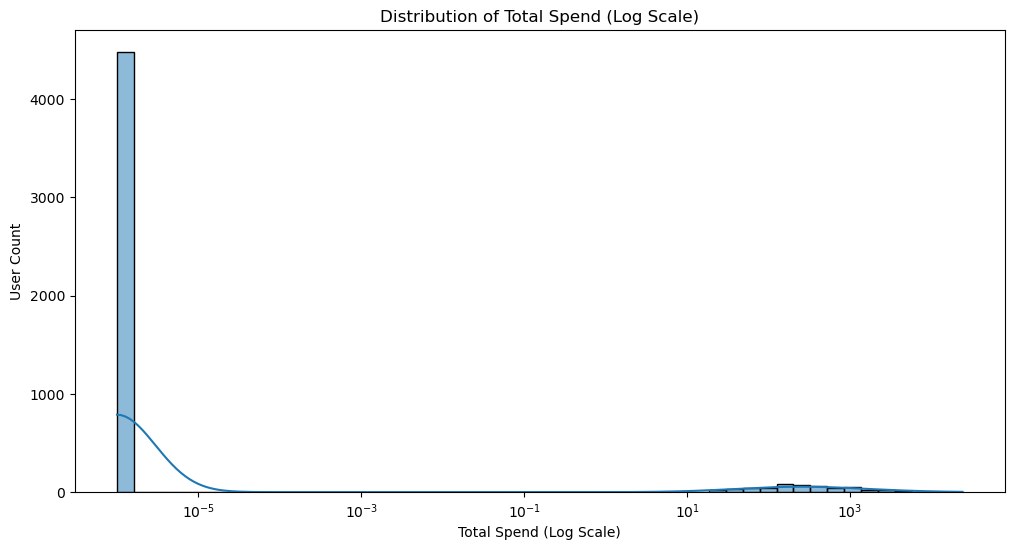

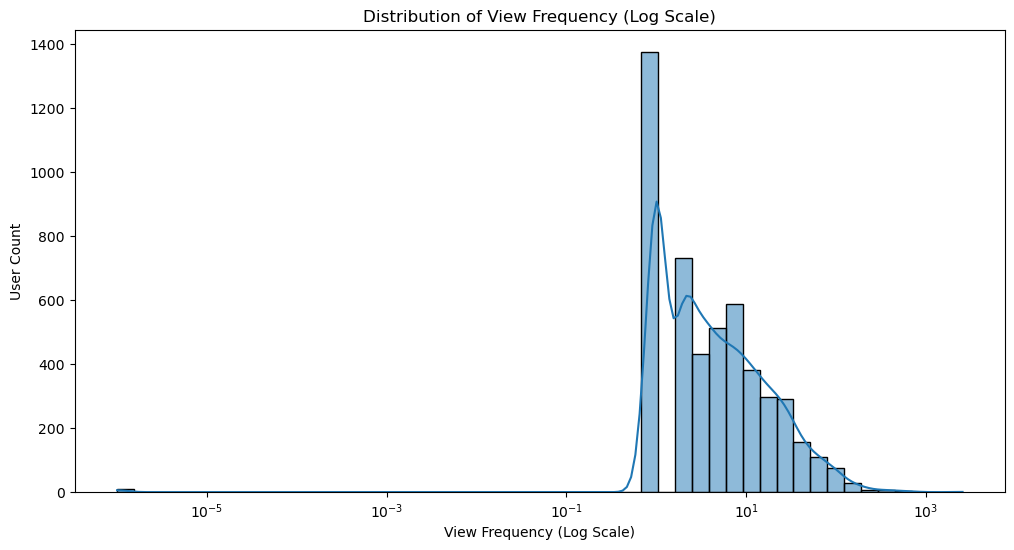

In [ ]:
# Cell 2: Visualization (Check distribution shape)
print("--- [Cell 2] Running: Sampling and visualizing distributions ---")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# (We define this list again so the cell is independent)
features_to_analyze = [
    "view_freq",
    "cart_freq",
    "purchase_freq",
    "total_spend",
    "add_to_cart_rate",
    "avg_spending",
    "session_duration_sec"
]

# 1. Randomly sample 5000 users (Sampling)
# (If 5000 is too slow, change to 1000)
sample_pandas_df = final_df.select(features_to_analyze).sample(
    withReplacement=False,
    fraction=0.01, # Try to sample 1% of the data (increase if too small)
    seed=42
).limit(5000).toPandas() # Max 5000 rows

print(f"Successfully sampled {len(sample_pandas_df)} rows for visualization.")

# 2. Draw histograms to check for skewness
# We focus on total_spend and view_freq (they are most likely skewed)
# We use a logarithmic scale (log_scale) on the x-axis to "flatten" the long tail

plt.figure(figsize=(12, 6))
# To avoid log(0) error, we add a very small value to the data
sample_pandas_df['total_spend_safe'] = sample_pandas_df['total_spend'] + 1e-6
sns.histplot(sample_pandas_df['total_spend_safe'], bins=50, kde=True, log_scale=True)
plt.title('Distribution of Total Spend (Log Scale)')
plt.xlabel('Total Spend (Log Scale)')
plt.ylabel('User Count')
plt.savefig('total_spend_distribution.png')
print("Total Spend distribution plot saved as total_spend_distribution.png")

plt.figure(figsize=(12, 6))
sample_pandas_df['view_freq_safe'] = sample_pandas_df['view_freq'] + 1e-6
sns.histplot(sample_pandas_df['view_freq_safe'], bins=50, kde=True, log_scale=True)
plt.title('Distribution of View Frequency (Log Scale)')
plt.xlabel('View Frequency (Log Scale)')
plt.ylabel('User Count')
plt.savefig('view_freq_distribution.png')
print("View Frequency distribution plot saved as view_freq_distribution.png")

print("--- [Cell 2] Complete. Please check the .png files in the GCS/Dataproc left-side file panel. ---")

--- [Cell 3] Running: Calculating feature correlation matrix ---


Correlation Matrix (Raw Array):
[[ 1.          0.22098207  0.17213519  0.10313027 -0.00206058  0.07920206
   0.25541479]
 [ 0.22098207  1.          0.78703004  0.59141759  0.3311157   0.30867006
   0.2426971 ]
 [ 0.17213519  0.78703004  1.          0.76651801  0.11107222  0.31460129
   0.18663313]
 [ 0.10313027  0.59141759  0.76651801  1.          0.08313598  0.42009792
   0.12103237]
 [-0.00206058  0.3311157   0.11107222  0.08313598  1.          0.17683359
   0.01192305]
 [ 0.07920206  0.30867006  0.31460129  0.42009792  0.17683359  1.
   0.15270972]
 [ 0.25541479  0.2426971   0.18663313  0.12103237  0.01192305  0.15270972
   1.        ]]
Correlation heatmap saved as correlation_matrix.png
--- [Cell 3] Complete. Please check the .png file. ---


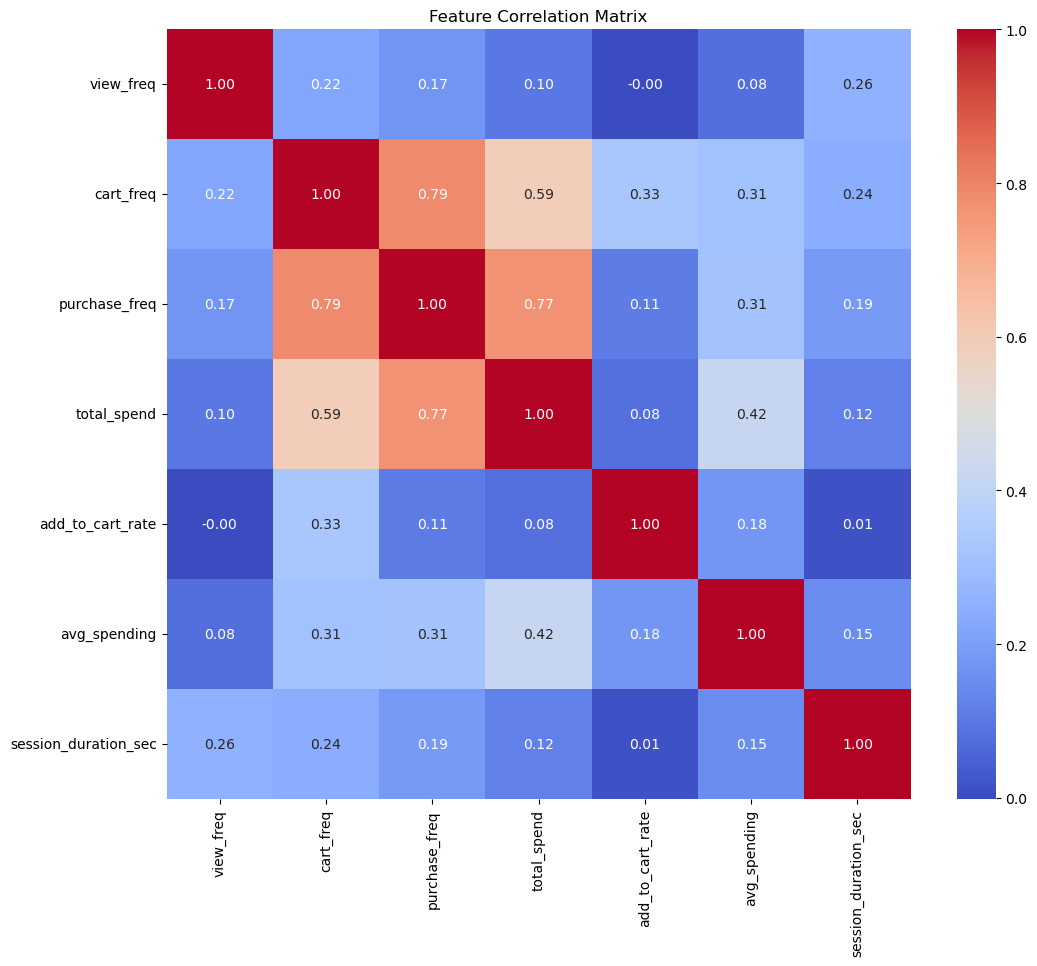

In [ ]:
# Cell 3: Correlation Analysis (Check feature relationships)
print("--- [Cell 3] Running: Calculating feature correlation matrix ---")

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
import matplotlib.pyplot as plt

# (We define this list again so the cell is independent)
features_to_analyze = [
    "view_freq",
    "cart_freq",
    "purchase_freq",
    "total_spend",
    "add_to_cart_rate",
    "avg_spending",
    "session_duration_sec"
]

# 1. Combine all features into a single "vector"
# This is required by Spark MLlib
assembler = VectorAssembler(inputCols=features_to_analyze, outputCol="features")
df_vector = assembler.transform(final_df).select("features")

# 2. Calculate the Pearson correlation matrix
correlation_matrix_spark = Correlation.corr(df_vector, "features").head()
matrix_array = correlation_matrix_spark[0].toArray()

print("Correlation Matrix (Raw Array):")
print(matrix_array)

# 3. (Optional) Plot a heatmap with Seaborn for a clearer view
plt.figure(figsize=(12, 10))
sns.heatmap(
    matrix_array,
    annot=True,         # Show numbers on the grid
    fmt=".2f",          # Format numbers to two decimal places
    xticklabels=features_to_analyze,
    yticklabels=features_to_analyze,
    cmap="coolwarm"     # Use blue-red colormap
)
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png')
print("Correlation heatmap saved as correlation_matrix.png")

print("--- [Cell 3] Complete. Please check the .png file. ---")

In [ ]:
# Cell 4: K-Means Preprocessing Pipeline (Revised Version - Compatible with older Spark)
print("--- [Cell 4 - Revised Version] Running: Building K-Means preprocessing pipeline ---")
print("PowerTransformer unavailable detected, switching to manual Log + StandardScaler method.")

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.functions import col

# 1. Define the features we will use for K-Means
features_for_kmeans = [
    "view_freq",
    "cart_freq",
    "purchase_freq",
    "total_spend",
    "session_duration_sec"
]

# 2. Step A: Manual Log Transform (to cure "skewness")
# (To prevent Log(0) errors, we add 1 to zero values)
df_log_transformed = final_df

# We will create a new "log_..." column for each feature
log_feature_cols = [] # This will be the new feature list fed to StandardScaler

for col_name in features_for_kmeans:
    safe_col = col_name + "_safe"
    log_col = "log_" + col_name

    # + 1.0 to avoid log(0)
    df_log_transformed = df_log_transformed.withColumn(safe_col, col(col_name) + 1.0)

    # Calculate the logarithm
    df_log_transformed = df_log_transformed.withColumn(log_col, F.log(col(safe_col)))

    # Add the new log_... column name to the list
    log_feature_cols.append(log_col)

print("Manual log transformation complete. New feature columns are:")
print(log_feature_cols)

# 3. Step B: Combine Vectors (VectorAssembler)
# We need to combine all new "log_..." columns into a single vector
log_assembler = VectorAssembler(
    inputCols=log_feature_cols,
    outputCol="log_features_vec"
)

# 4. Step C: Standardization (StandardScaler) - to cure "scale"
# StandardScaler will transform our log_features_vec to the same scale
scaler = StandardScaler(
    inputCol="log_features_vec",
    outputCol="scaled_features" # This is the final feature K-Means needs
)

# 5. Step D: Build the pipeline
# The pipeline will now execute in order: B -> C
pipeline = Pipeline(stages=[log_assembler, scaler])

# 6. Train the pipeline
print("Training the preprocessing pipeline (fitting StandardScaler)...")
# We train on the "log-transformed" table
pipeline_model = pipeline.fit(df_log_transformed)

# 7. Generate the final "K-Means ready" data
kmeans_ready_df = pipeline_model.transform(df_log_transformed)

print("--- [Cell 4] Complete! ---")
print("Generated 'K-Means ready' data (kmeans_ready_df).")
print("Data preview (look at the 'scaled_features' column):")
kmeans_ready_df.select("user_id", "scaled_features").show(5, truncate=False)

--- [Cell 4 - Revised Version] Running: Building K-Means preprocessing pipeline ---
PowerTransformer unavailable detected, switching to manual Log + StandardScaler method.
Manual log transformation complete. New feature columns are:
['log_view_freq', 'log_cart_freq', 'log_purchase_freq', 'log_total_spend', 'log_session_duration_sec']
Training the preprocessing pipeline (fitting StandardScaler)...


--- [Cell 4] Complete! ---
Generated 'K-Means ready' data (kmeans_ready_df).
Data preview (look at the 'scaled_features' column):
+---------+------------------------------------------------------------------+
|user_id  |scaled_features                                                   |
+---------+------------------------------------------------------------------+
|517341299|[3.169719180757255,2.797094748031856,0.0,0.0,2.5450621383317196]  |
|622107433|[1.6242991777010778,1.2046431386875245,0.0,0.0,2.4810454812263054]|
|601114478|(5,[0,4],[1.9918689620373171,2.5453481261948663])                 |
|524626237|[1.9918689620373171,1.2046431386875245,0.0,0.0,0.833634524417852] |
|561067042|[4.027434991505216,1.2046431386875245,0.0,0.0,2.603476117844006]  |
+---------+------------------------------------------------------------------+
only showing top 5 rows

